# Prototyping Settings for Simplistic DESC SRD Y1 after PGD implementation and average over 100 maps 

For reference, the DESC SRD can be found [here](https://arxiv.org/pdf/1809.01669.pdf). Appendix D2 specifies some of the analysis choices for the Y1 data. 

In particular:
- neff for lensing sources: 10 gal/arcmin^2
- sigma_e: 0.26 per component
- lmax: 3000

We will use a kappa TNG map as a reference point.

In [16]:
%pylab inline 
import tensorflow_addons as tfa
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import DifferentiableHOS as DHOS
import flowpm.scipy.interpolate as interpolate
import astropy.units as u
import jax_cosmo as jc
import pickle
from flowpm import tfpm
from scipy import ndimage, misc
import os
from matplotlib import gridspec

Populating the interactive namespace from numpy and matplotlib


/global/common/software/nersc/shasta2105/tensorflow/2.6.0/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
field_size=5.
field_npix=1024
z_source=tf.convert_to_tensor([1.034,0.858,1.163],dtype=tf.float32)

In [4]:
m=[]
m_nopgd=[]
for filename in os.listdir("/pscratch/sd/d/dlan/maps_noia/maps1/"):
        f=open(os.path.join('/pscratch/sd/d/dlan/maps_noia/maps1/', filename), 'rb')
        res1 =pickle.load(f)
        km=res1['m']
        km_nopgd=res1['m_nopgd']
        f.close()
        m.append(km)
        m_nopgd.append(km_nopgd)

In [5]:
for filename in os.listdir("/pscratch/sd/d/dlan/maps_noia/maps2/"):
        f=open(os.path.join('/pscratch/sd/d/dlan/maps_noia/maps2/', filename), 'rb')
        res1 =pickle.load(f)
        km=res1['m']
        km_nopgd=res1['m_nopgd']
        f.close()
        m.append(km)
        m_nopgd.append(km_nopgd)

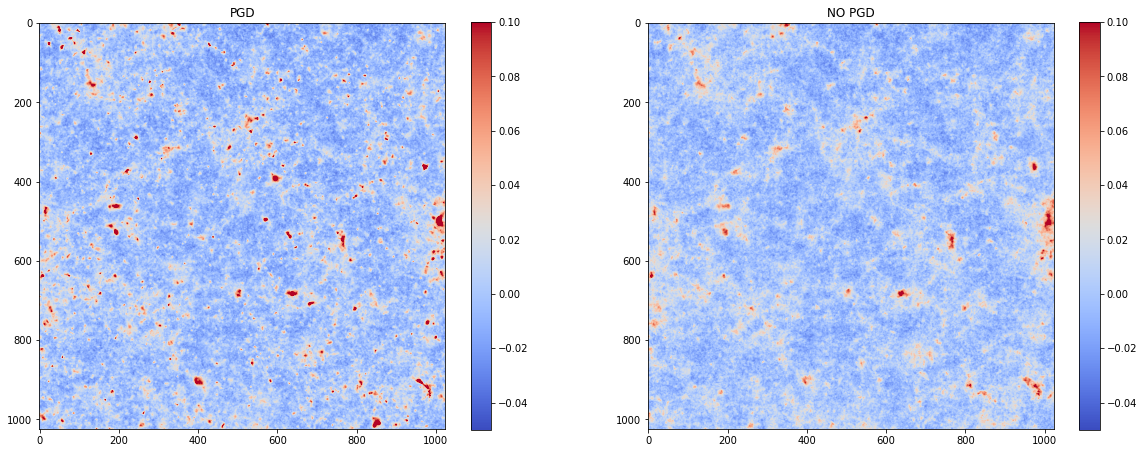

In [7]:
figure(figsize=[20,10])
subplot(121)
imshow(m[3][0],cmap='coolwarm',vmax=0.10,vmin=-0.05)
title('PGD');
colorbar(shrink=0.75)
subplot(122)
imshow(m_nopgd[3][0],cmap='coolwarm',vmax=0.10,vmin=-0.05)
title('NO PGD');
colorbar(shrink=0.75)

## Comparison to kappa TNG

For comparison, we are using this map at redshift 1 from the kappa TNG simulations.

In [8]:
kTNG_23=[]

for filename in os.listdir("/global/cfs/cdirs/lsst/shared/external/kappaTNG/kappaTNG-Dark"):
    fname=os.path.join('/global/cfs/cdirs/lsst/shared/external/kappaTNG/kappaTNG-Dark',  filename+"/run001/kappa23.dat")
    with open(fname, 'rb') as f:
        dummy = np.fromfile(f, dtype="int32", count=1)
        kappaTNG = np.fromfile(f, dtype="float", count=field_npix* field_npix)
        dummy = np.fromfile(f, dtype="int32", count=1)
    kappaTNG = kappaTNG.reshape((field_npix, field_npix))
    kTNG_23.append(kappaTNG)


In [10]:
kTNG_20=[]

for filename in os.listdir("/global/cfs/cdirs/lsst/shared/external/kappaTNG/kappaTNG-Dark"):
    fname=os.path.join('/global/cfs/cdirs/lsst/shared/external/kappaTNG/kappaTNG-Dark',  filename+"/run001/kappa20.dat")
    with open(fname, 'rb') as f:
        dummy = np.fromfile(f, dtype="int32", count=1)
        kappaTNG = np.fromfile(f, dtype="float", count=field_npix* field_npix)
        dummy = np.fromfile(f, dtype="int32", count=1)
    kappaTNG = kappaTNG.reshape((field_npix, field_npix))
    kTNG_20.append(kappaTNG)


In [11]:
kTNG_25=[]

for filename in os.listdir("/global/cfs/cdirs/lsst/shared/external/kappaTNG/kappaTNG-Dark"):
    fname=os.path.join('/global/cfs/cdirs/lsst/shared/external/kappaTNG/kappaTNG-Dark',  filename+"/run001/kappa25.dat")
    with open(fname, 'rb') as f:
        dummy = np.fromfile(f, dtype="int32", count=1)
        kappaTNG = np.fromfile(f, dtype="float", count=field_npix* field_npix)
        dummy = np.fromfile(f, dtype="int32", count=1)
    kappaTNG = kappaTNG.reshape((field_npix, field_npix))
    kTNG_25.append(kappaTNG)


In [13]:
ps_kTNG_20=[]
ps_kTNG_23=[]
ps_kTNG_25=[]
for i in range(100):
    l,ps_20=DHOS.statistics.power_spectrum(kTNG_20[i],field_size,field_npix)
    l,ps_23=DHOS.statistics.power_spectrum(kTNG_23[i],field_size,field_npix)
    l,ps_25=DHOS.statistics.power_spectrum(kTNG_25[i],field_size,field_npix)
    ps_kTNG_20.append(ps_20)
    ps_kTNG_23.append(ps_23)
    ps_kTNG_25.append(ps_25)

In [14]:
ps_kTNG_20mean=np.mean(ps_kTNG_20,axis=0)
ps_kTNG_23mean=np.mean(ps_kTNG_23,axis=0)
ps_kTNG_25mean=np.mean(ps_kTNG_25,axis=0)

In [18]:
cls_mean=np.load("/global/homes/d/dlan/DifferentiableHOS/notebooks/cls_mean.npy")
cls_nopgd_mean=np.load("/global/homes/d/dlan/DifferentiableHOS/notebooks/cls_nopgd_mean.npy")

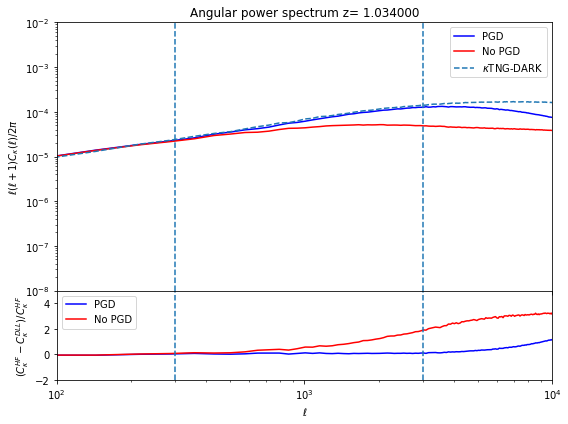

In [20]:
j=0
fig = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(l, l*(l+1)*cls_mean[j]/(2*np.pi),label='PGD',color='blue')
ax0.loglog(l, l*(l+1)*cls_nopgd_mean[j]/(2*np.pi),label='No PGD',color='red')
ax0.loglog(l, l*(l+1)*ps_kTNG_23mean/(2*np.pi),'--',label='$\kappa$TNG-DARK')
ax0.set_title('Angular power spectrum z= %f' %(z_source[j]))
ax0.set_xlim(1e2,1e4)
ax0.set_ylim(1e-8,1e-2)
ax0.label_outer()
ax0.set_ylabel('$\ell(\ell+1)C_{\kappa}(\ell) /2\pi$')
plt.legend()
axvline(300,ls='--')
axvline(3000,ls='--')
ax1 = plt.subplot(gs[1])
ax1.plot(l, ps_kTNG_23mean/cls_mean[j]-1,label='PGD',color='blue')
ax1.plot(l, ps_kTNG_23mean/cls_nopgd_mean[j]-1,label='No PGD',color='red')
ax1.set_xscale('log')
plt.legend()
ax1.set_xlim(1e2,1e4)
ax1.set_ylabel('$(C_{\kappa}^{HF}-C_{\kappa}^{DLL})/C_{\kappa}^{HF}$')
ax1.set_xlabel('$\ell$')
ax1.set_ylim(-2,5)
axvline(300,ls='--')
axvline(3000,ls='--')
plt.tight_layout()

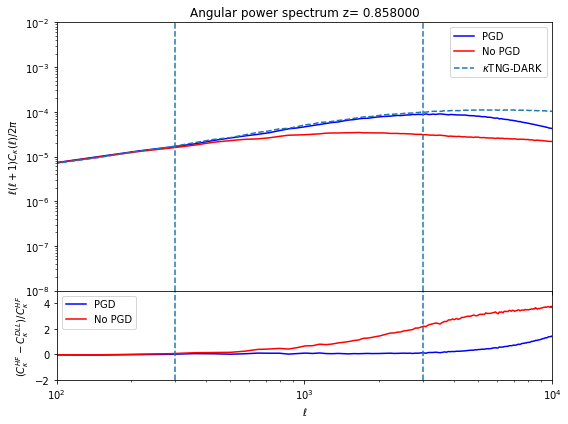

In [24]:
j=1
fig = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(l, l*(l+1)*cls_mean[j]/(2*np.pi),label='PGD',color='blue')
ax0.loglog(l, l*(l+1)*cls_nopgd_mean[j]/(2*np.pi),label='No PGD',color='red')
ax0.loglog(l, l*(l+1)*ps_kTNG_20mean/(2*np.pi),'--',label='$\kappa$TNG-DARK')
ax0.set_title('Angular power spectrum z= %f' %(z_source[j]))
ax0.set_xlim(1e2,1e4)
ax0.set_ylim(1e-8,1e-2)
ax0.label_outer()
ax0.set_ylabel('$\ell(\ell+1)C_{\kappa}(\ell) /2\pi$')
plt.legend()
axvline(300,ls='--')
axvline(3000,ls='--')
ax1 = plt.subplot(gs[1])
ax1.plot(l, ps_kTNG_20mean/cls_mean[j]-1,label='PGD',color='blue')
ax1.plot(l, ps_kTNG_20mean/cls_nopgd_mean[j]-1,label='No PGD',color='red')
ax1.set_xscale('log')
plt.legend()
ax1.set_xlim(1e2,1e4)
ax1.set_ylabel('$(C_{\kappa}^{HF}-C_{\kappa}^{DLL})/C_{\kappa}^{HF}$')
ax1.set_xlabel('$\ell$')
ax1.set_ylim(-2,5)
axvline(300,ls='--')
axvline(3000,ls='--')
plt.tight_layout()

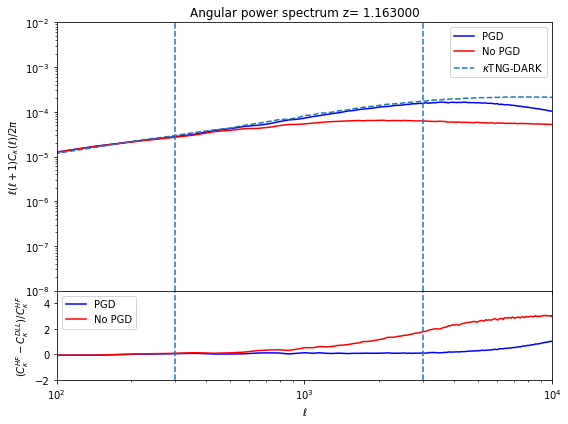

In [25]:
j=2
fig = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(l, l*(l+1)*cls_mean[j]/(2*np.pi),label='PGD',color='blue')
ax0.loglog(l, l*(l+1)*cls_nopgd_mean[j]/(2*np.pi),label='No PGD',color='red')
ax0.loglog(l, l*(l+1)*ps_kTNG_25mean/(2*np.pi),'--',label='$\kappa$TNG-DARK')
ax0.set_title('Angular power spectrum z= %f' %(z_source[j]))
ax0.set_xlim(1e2,1e4)
ax0.set_ylim(1e-8,1e-2)
ax0.label_outer()
ax0.set_ylabel('$\ell(\ell+1)C_{\kappa}(\ell) /2\pi$')
plt.legend()
axvline(300,ls='--')
axvline(3000,ls='--')
ax1 = plt.subplot(gs[1])
ax1.plot(l, ps_kTNG_25mean/cls_mean[j]-1,label='PGD',color='blue')
ax1.plot(l, ps_kTNG_25mean/cls_nopgd_mean[j]-1,label='No PGD',color='red')
ax1.set_xscale('log')
plt.legend()
ax1.set_xlim(1e2,1e4)
ax1.set_ylabel('$(C_{\kappa}^{HF}-C_{\kappa}^{DLL})/C_{\kappa}^{HF}$')
ax1.set_xlabel('$\ell$')
ax1.set_ylim(-2,5)
axvline(300,ls='--')
axvline(3000,ls='--')
plt.tight_layout()

Let's see the maps in the same colorscale 

(-0.5, 1023.5, 1023.5, -0.5)

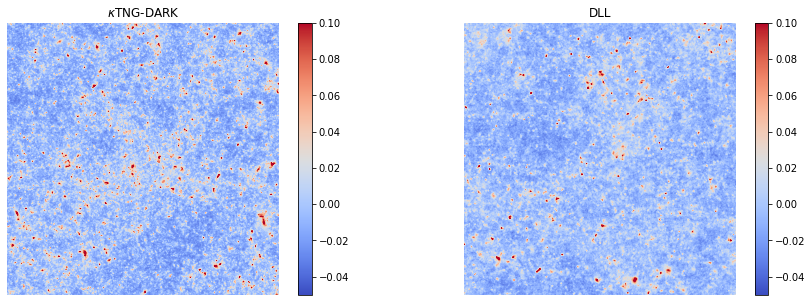

In [23]:
# Here is what it looks like with smoothin 
figure(figsize=[15,5])
subplot(121)
title('$\kappa$TNG-DARK')
imshow(kTNG_23[0],cmap='coolwarm',vmax=0.10,vmin=-0.05)
colorbar()
axis('off')
subplot(122)
title('DLL')
imshow(m[0][0],cmap='coolwarm',vmax=0.10,vmin=-0.05)
colorbar()
axis('off')
#savefig('maps_comp_same.png',dpi=250)

In [ ]:
# %pylab inline 
# y=ps_kTNG_23mean/cls_mean[j]-1
# ci=ps_flowpm_std
# fig, ax = plt.subplots()
# plt.semilogx(l, y)
# xlim(1e2,1e4)
# ylim(-1,0.75)
# ax.fill_between(l, y-ci/ps_kTNGmean, y+ci/ps_kTNGmean, alpha=.2)
# ylabel('$C_{\ell}^{DLL}/C_\ell^{\kappa TNG}-1$')
# xlabel('$\ell$')
# axvline(3000, ls='--')
# axvline(300, ls='--')
# title('Comparison to $\kappa$$TNG-DARK$')
# #savefig('res_cl_dll_ktng_64.png',dpi=250)

So, obvioulsy our 128^3 simulation is not as precise as kappa TNG, but we won't be working at the native 0.3 arcmin resolution anyway, in practice we'll have noise and smoothing.

So let's see how much smoothing gets us in the right ball park.

In [26]:
ngal = 10                          # gal/arcmin **2
pix_scale =field_size/field_npix*60              # arcmin
ngal_per_pix = ngal * pix_scale**2 # galaxies per pixels
sigma_e = 0.26 / sqrt(2 * ngal_per_pix) # Rescaled noise sigma

In [27]:
sigma_pix=1./pix_scale


In [28]:

def perf_smoothing(kmap):
    kmap= numpy.fft.fft2(kmap)
    kmap =ndimage.fourier_gaussian(kmap, sigma=sigma_pix)
    kmap=numpy.fft.ifft2(kmap)
    kmap=kmap.real
    return kmap

#### 1arcmin smoothing

Populating the interactive namespace from numpy and matplotlib


(-0.5, 1023.5, 1023.5, -0.5)

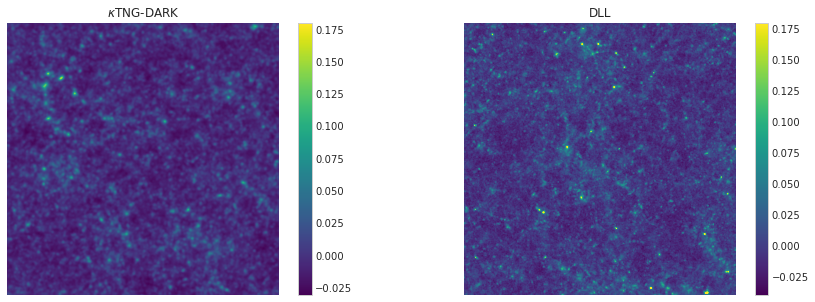

In [18]:
%pylab inline 
figure(figsize=[15,5])
subplot(121)
title('$\kappa$TNG-DARK')
imshow(perf_smoothing(kTNG_array[5]),cmap='viridis',vmax=0.18)
colorbar()
axis('off')

subplot(122)
title('DLL')
imshow(kmaps[5][0],cmap='viridis',vmax=0.18)
colorbar()
axis('off')

In [31]:
ps_r_1arc=[]
ps_nopgd_r_1arc=[]
for i in range(len(m)):
        ps=[]
        ps_nopgd=[]
        for j in range(3):
            l,p=DHOS.statistics.power_spectrum(perf_smoothing(m[i][j]),field_size,field_npix) 
            l,pp= DHOS.statistics.power_spectrum(perf_smoothing(m_nopgd[i][j]),field_size,field_npix)
            ps.append(p)
            ps_nopgd.append(pp)   
        ps_r_1arc.append(ps)
        ps_nopgd_r_1arc.append(ps_nopgd)

In [42]:
cls_nopgd_mean_1arc=np.mean(ps_nopgd_r_1arc,axis=0)
cls_pgd_mean_1arc=np.mean(ps_r_1arc,axis=0)

In [38]:
ps_TNG_20_1arc=[]
for kmap in (kTNG_20):
    l, ps_kTNG= DHOS.statistics.power_spectrum(perf_smoothing(kmap),field_size,field_npix)
    ps_TNG_20_1arc.append(ps_kTNG)
ps_kTNG_mean20_1arc=np.mean(ps_TNG_20_1arc,axis=0)

In [39]:
ps_TNG_23_1arc=[]
for kmap in (kTNG_23):
    l, ps_kTNG= DHOS.statistics.power_spectrum(perf_smoothing(kmap),field_size,field_npix)
    ps_TNG_23_1arc.append(ps_kTNG)
ps_kTNG_mean23_1arc=np.mean(ps_TNG_23_1arc,axis=0)

In [40]:
ps_TNG_25_1arc=[]
for kmap in (kTNG_25):
    l, ps_kTNG= DHOS.statistics.power_spectrum(perf_smoothing(kmap),field_size,field_npix)
    ps_TNG_25_1arc.append(ps_kTNG)
ps_kTNG_mean25_1arc=np.mean(ps_TNG_25_1arc,axis=0)

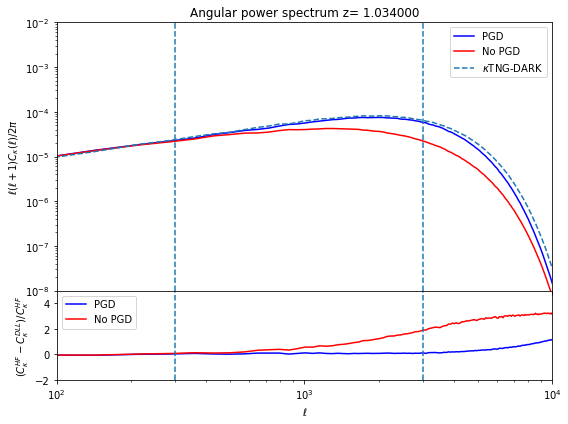

In [46]:
j=0
fig = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(l, l*(l+1)*cls_pgd_mean_1arc[j]/(2*np.pi),label='PGD',color='blue')
ax0.loglog(l, l*(l+1)*cls_nopgd_mean_1arc[j]/(2*np.pi),label='No PGD',color='red')
ax0.loglog(l, l*(l+1)*ps_kTNG_mean23_1arc/(2*np.pi),'--',label='$\kappa$TNG-DARK')
ax0.set_title('Angular power spectrum z= %f' %(z_source[j]))
ax0.set_xlim(1e2,1e4)
ax0.set_ylim(1e-8,1e-2)
ax0.label_outer()
ax0.set_ylabel('$\ell(\ell+1)C_{\kappa}(\ell) /2\pi$')
plt.legend()
axvline(300,ls='--')
axvline(3000,ls='--')
ax1 = plt.subplot(gs[1])
ax1.plot(l, ps_kTNG_mean23_1arc/cls_pgd_mean_1arc[j]-1,label='PGD',color='blue')
ax1.plot(l, ps_kTNG_mean23_1arc/cls_nopgd_mean_1arc[j]-1,label='No PGD',color='red')
ax1.set_xscale('log')
plt.legend()
ax1.set_xlim(1e2,1e4)
ax1.set_ylabel('$(C_{\kappa}^{HF}-C_{\kappa}^{DLL})/C_{\kappa}^{HF}$')
ax1.set_xlabel('$\ell$')
ax1.set_ylim(-2,5)
axvline(300,ls='--')
axvline(3000,ls='--')
plt.tight_layout()

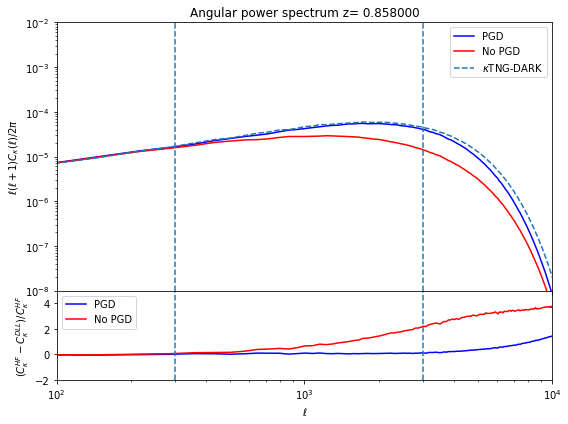

In [47]:
j=1
fig = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(l, l*(l+1)*cls_pgd_mean_1arc[j]/(2*np.pi),label='PGD',color='blue')
ax0.loglog(l, l*(l+1)*cls_nopgd_mean_1arc[j]/(2*np.pi),label='No PGD',color='red')
ax0.loglog(l, l*(l+1)*ps_kTNG_mean20_1arc/(2*np.pi),'--',label='$\kappa$TNG-DARK')
ax0.set_title('Angular power spectrum z= %f' %(z_source[j]))
ax0.set_xlim(1e2,1e4)
ax0.set_ylim(1e-8,1e-2)
ax0.label_outer()
ax0.set_ylabel('$\ell(\ell+1)C_{\kappa}(\ell) /2\pi$')
plt.legend()
axvline(300,ls='--')
axvline(3000,ls='--')
ax1 = plt.subplot(gs[1])
ax1.plot(l, ps_kTNG_mean20_1arc/cls_pgd_mean_1arc[j]-1,label='PGD',color='blue')
ax1.plot(l, ps_kTNG_mean20_1arc/cls_nopgd_mean_1arc[j]-1,label='No PGD',color='red')
ax1.set_xscale('log')
plt.legend()
ax1.set_xlim(1e2,1e4)
ax1.set_ylabel('$(C_{\kappa}^{HF}-C_{\kappa}^{DLL})/C_{\kappa}^{HF}$')
ax1.set_xlabel('$\ell$')
ax1.set_ylim(-2,5)
axvline(300,ls='--')
axvline(3000,ls='--')
plt.tight_layout()

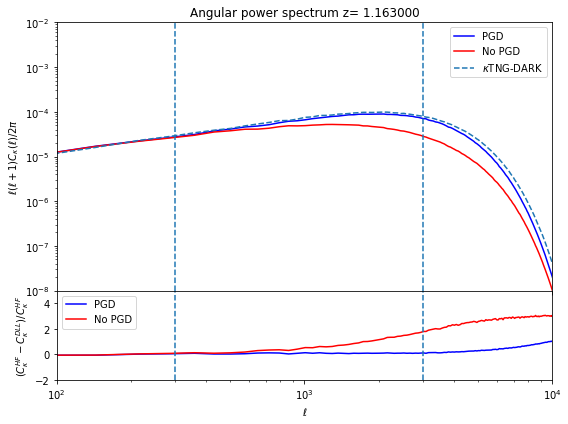

In [48]:
j=2
fig = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(l, l*(l+1)*cls_pgd_mean_1arc[j]/(2*np.pi),label='PGD',color='blue')
ax0.loglog(l, l*(l+1)*cls_nopgd_mean_1arc[j]/(2*np.pi),label='No PGD',color='red')
ax0.loglog(l, l*(l+1)*ps_kTNG_mean25_1arc/(2*np.pi),'--',label='$\kappa$TNG-DARK')
ax0.set_title('Angular power spectrum z= %f' %(z_source[j]))
ax0.set_xlim(1e2,1e4)
ax0.set_ylim(1e-8,1e-2)
ax0.label_outer()
ax0.set_ylabel('$\ell(\ell+1)C_{\kappa}(\ell) /2\pi$')
plt.legend()
axvline(300,ls='--')
axvline(3000,ls='--')
ax1 = plt.subplot(gs[1])
ax1.plot(l, ps_kTNG_mean25_1arc/cls_pgd_mean_1arc[j]-1,label='PGD',color='blue')
ax1.plot(l, ps_kTNG_mean25_1arc/cls_nopgd_mean_1arc[j]-1,label='No PGD',color='red')
ax1.set_xscale('log')
plt.legend()
ax1.set_xlim(1e2,1e4)
ax1.set_ylabel('$(C_{\kappa}^{HF}-C_{\kappa}^{DLL})/C_{\kappa}^{HF}$')
ax1.set_xlabel('$\ell$')
ax1.set_ylim(-2,5)
axvline(300,ls='--')
axvline(3000,ls='--')
plt.tight_layout()

In [50]:
cls_nopgd_std_1arc=np.std(ps_nopgd_r_1arc,axis=0)
cls_pgd_std_1arc=np.std(ps_r_1arc,axis=0)
ps_kTNG_std20_1arc=np.std(ps_TNG_20_1arc,axis=0)
ps_kTNG_std23_1arc=np.std(ps_TNG_23_1arc,axis=0)
ps_kTNG_std25_1arc=np.std(ps_TNG_25_1arc,axis=0)

Text(0.5, 1.0, '1-arcmin smoothing')

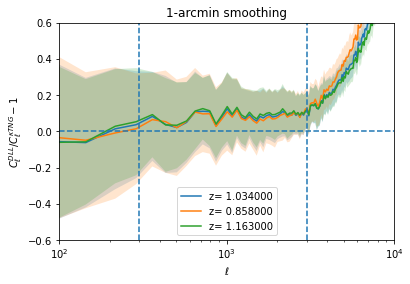

In [63]:
y23=ps_kTNG_mean23_1arc/cls_pgd_mean_1arc[0]-1
y20=ps_kTNG_mean20_1arc/cls_pgd_mean_1arc[1]-1
y25=ps_kTNG_mean25_1arc/cls_pgd_mean_1arc[2]-1
ci20=ps_kTNG_std20_1arc
ci23=ps_kTNG_std23_1arc
ci25=ps_kTNG_std25_1arc
fig, ax = plt.subplots()
plt.semilogx(l, y23,label='z= %f' %(z_source[0]))
plt.semilogx(l, y20,label='z= %f' %(z_source[1]))
plt.semilogx(l, y25,label='z= %f' %(z_source[2]))
axvline(3000, ls='--')
axvline(300, ls='--')
axhline(0, ls='--')
xlim(1e2,1e4)
ylim(-0.6,0.6)
ax.fill_between(l, y23-ci23/ps_kTNG_mean23_1arc, y23+ci23/ps_kTNG_mean23_1arc, alpha=.2)
ax.fill_between(l, y20-ci20/ps_kTNG_mean20_1arc, y20+ci20/ps_kTNG_mean20_1arc, alpha=.2)
ax.fill_between(l, y25-ci25/ps_kTNG_mean25_1arc, y25+ci25/ps_kTNG_mean25_1arc, alpha=.2)
ylabel('$C_{\ell}^{DLL}/C_\ell^{\kappa TNG}-1$')
xlabel('$\ell$')
legend()
title('1-arcmin smoothing')
#savefig('res_cl_dll_ktng_64_2smo.png',dpi=250)

#### 1arcmin smoothing

In [61]:
l1norm_FLO_array_1n=[] 
for kmap in (kmaps):
    kmap= kmap+ sigma_e * randn(1024,1024), 5*u.deg
    kmap=np.float32(perf_smoothing(kmap[0][0]))
    kmap=tf.expand_dims(kmap, axis=0)
    l1norm_FLO= DHOS.statistics.l1norm(kmap,nscales=7, nbins=8, value_range=[-0.05, 0.05])
    l1norm_FLO_array_1n.append(l1norm_FLO)
l1norm_FLO_mean_n_1arc=np.mean(l1norm_FLO_array_1n,axis=0)

In [62]:
l1norm_kTNG_array_1n=[] 
for kmap in (kTNG_array):
    kmap= kmap+ sigma_e * randn(1024,1024), 5*u.deg
    kmap=np.float32(perf_smoothing(kmap[0]))
    kmap=tf.expand_dims(kmap, axis=0)
    l1norm_kTNG= DHOS.statistics.l1norm(kmap,nscales=7, nbins=8, value_range=[-0.05, 0.05])
    l1norm_kTNG_array_1n.append(l1norm_kTNG)
l1norm_kTNG_mean_n_1arc=np.mean(l1norm_kTNG_array_1n,axis=0)

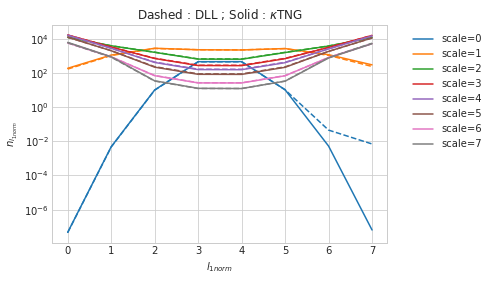

In [63]:
for i,key in zip(range(8),mcolors.TABLEAU_COLORS):
    semilogy(l1norm_kTNG_mean_n_1arc[i], label='scale='+str(i),color=key)
    semilogy(l1norm_FLO_mean_n_1arc[i],'--',color=key)
title("Dashed : DLL ; Solid : $\kappa$TNG")
ylabel('$n_{l_{1norm}}$')
xlabel('$l_{1norm}$')
legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [64]:
l1norm_kTNG_std_n_1arc=np.std(l1norm_kTNG_array_1n,axis=0)

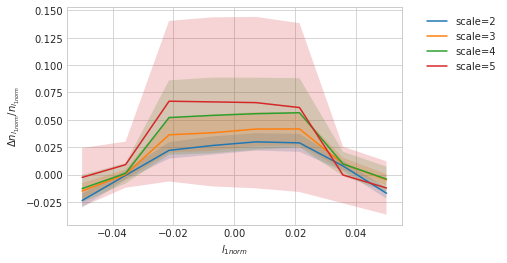

In [65]:
x=np.linspace(-0.05, 0.05,8)
fig, ax = plt.subplots()
for i in range(2,6):
    y=(l1norm_FLO_mean_n_1arc[i]-l1norm_kTNG_mean_n_1arc[i])/l1norm_kTNG_mean_n_1arc[i]
    ci=l1norm_kTNG_std_n_1arc[i]  
    ax.plot(x,y,label='scale='+str(i))
    ax.fill_between(x,y-ci/l1norm_kTNG_mean_n_1arc[i], y+ci/l1norm_kTNG_mean_n_1arc[i], alpha=.2)
# ylim(-0.20,0.20)
ylabel('$\Delta$$n_{l_{1norm}}/n_{l_{1norm}}$')
xlabel('$l_{1norm}$')
legend(bbox_to_anchor=(1.05, 1), loc='upper left')